# Rota Inteligente — Sabor Express (Dijkstra + K-Means)

Este notebook demonstra uma solução simples e completa para otimização de entregas:
1) **Grafo** da cidade (bairros como nós, ruas como arestas com pesos de tempo/distância).
2) **Rotas mais curtas** com **Dijkstra** e **A\*** (heurística euclidiana).
3) **Agrupamento (K-Means)** para dividir pedidos em zonas eficientes.
4) **Roteiro de execução** e análises rápidas.

> **Como usar no Colab:** criar a pasta `data/` (contendo nodes.csv, edges.csv, deliveries.csv).


In [1]:
import os

# cria a pasta "data" dentro do ambiente do Colab
os.makedirs("data", exist_ok=True)

print("✅ Pasta 'data' criada com sucesso!")


✅ Pasta 'data' criada com sucesso!


In [2]:
nodes_csv = """node,x,y
Base,0,0
Centro,2,1
Bairro A,4,1
Bairro B,1,3
Bairro C,5,3
Bairro D,3,5
Bairro E,6,0
Bairro F,7,4
"""

with open("data/nodes.csv", "w", encoding="utf-8") as f:
    f.write(nodes_csv)

print("✅ Arquivo nodes.csv criado dentro da pasta data/")


✅ Arquivo nodes.csv criado dentro da pasta data/


In [3]:
edges_csv = """u,v,weight
Base,Centro,2.2
Base,Bairro B,3.0
Centro,Bairro A,2.0
Centro,Bairro B,2.1
Bairro A,Bairro C,2.2
Bairro C,Bairro D,2.4
Bairro A,Bairro E,2.6
Bairro E,Bairro F,2.2
Bairro C,Bairro F,1.8
Bairro B,Bairro D,2.7
Centro,Bairro D,3.2
"""

with open("data/edges.csv", "w", encoding="utf-8") as f:
    f.write(edges_csv)

print("✅ Arquivo edges.csv criado dentro da pasta data/")


✅ Arquivo edges.csv criado dentro da pasta data/


In [4]:
deliveries_csv = """id,node
1,Bairro A
2,Bairro C
3,Bairro D
4,Bairro F
"""

with open("data/deliveries.csv", "w", encoding="utf-8") as f:
    f.write(deliveries_csv)

print("✅ Arquivo deliveries.csv criado dentro da pasta data/")


✅ Arquivo deliveries.csv criado dentro da pasta data/


In [5]:
import os
print("Arquivos na pasta data:")
print(os.listdir("data"))


Arquivos na pasta data:
['deliveries.csv', 'nodes.csv', 'edges.csv']


In [6]:
# !pip install networkx scikit-learn matplotlib

import csv, math, os
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


BASE_DIR = "."
DATA_DIR = os.path.join(BASE_DIR, "data")

nodes_path = os.path.join(DATA_DIR, "nodes.csv")
edges_path = os.path.join(DATA_DIR, "edges.csv")
deliveries_path = os.path.join(DATA_DIR, "deliveries.csv")


## 1) **Grafo** da cidade
- (bairros como nós, ruas como arestas com pesos de tempo/distância).

Nós: ['Base', 'Centro', 'Bairro A', 'Bairro B', 'Bairro C', 'Bairro D', 'Bairro E', 'Bairro F']
Arestas (exemplo): [('Base', 'Centro', {'weight': 2.2}), ('Base', 'Bairro B', {'weight': 3.0}), ('Centro', 'Bairro A', {'weight': 2.0}), ('Centro', 'Bairro B', {'weight': 2.1}), ('Centro', 'Bairro D', {'weight': 3.2}), ('Bairro A', 'Bairro C', {'weight': 2.2}), ('Bairro A', 'Bairro E', {'weight': 2.6}), ('Bairro B', 'Bairro D', {'weight': 2.7}), ('Bairro C', 'Bairro D', {'weight': 2.4}), ('Bairro C', 'Bairro F', {'weight': 1.8})]
Entregas: ['Bairro A', 'Bairro C', 'Bairro D', 'Bairro F']


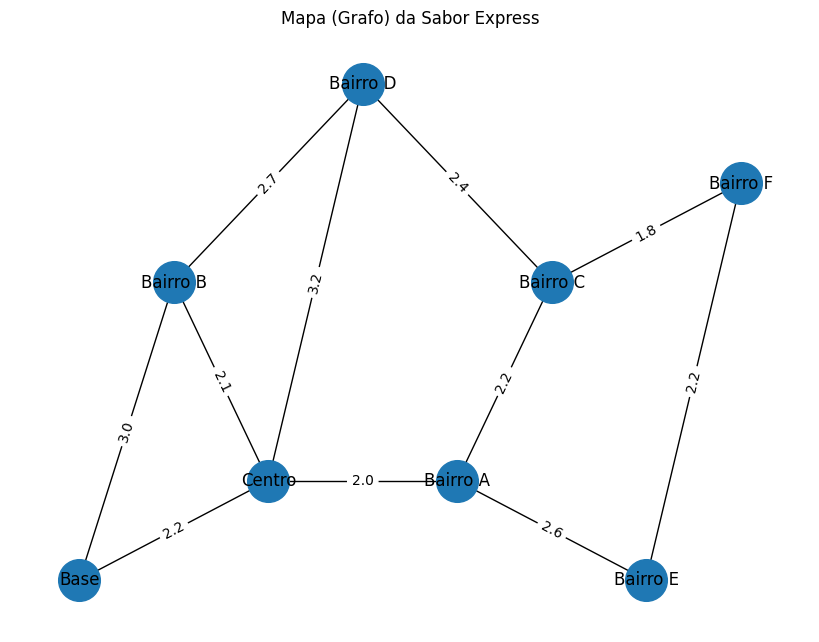

In [7]:
# Carregar nós (com coordenadas para visualização e heurística)
pos = {}
with open(nodes_path, encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        pos[row["node"]] = (float(row["x"]), float(row["y"]))

# Construção do grafo ponderado
G = nx.Graph()
G.add_nodes_from(pos.keys())
with open(edges_path, encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        u, v, w = row["u"], row["v"], float(row["weight"])
        G.add_edge(u, v, weight=w)

# Carregar entregas (mapeadas a nós existentes)
deliveries = []
with open(deliveries_path, encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        deliveries.append(row["node"])

print("Nós:", list(G.nodes()))
print("Arestas (exemplo):", list(G.edges(data=True))[:10])
print("Entregas:", deliveries)

# Visualização do grafo
plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=True, node_size=900)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Mapa (Grafo) da Sabor Express")
plt.show()


## 2) Rotas mais curtas: Dijkstra e A*
- **Dijkstra**: ótimo para grafos com pesos positivos.
- **A***: usa uma heurística (aqui, distância euclidiana) para acelerar a busca.


[Dijkstra] Base -> Bairro A: caminho=['Base', 'Centro', 'Bairro A'], distância=4.20
[A*]       Base -> Bairro A: caminho=['Base', 'Centro', 'Bairro A'], distância=4.20
----------------------------------------------------------------------
[Dijkstra] Base -> Bairro C: caminho=['Base', 'Centro', 'Bairro A', 'Bairro C'], distância=6.40
[A*]       Base -> Bairro C: caminho=['Base', 'Centro', 'Bairro A', 'Bairro C'], distância=6.40
----------------------------------------------------------------------
[Dijkstra] Base -> Bairro D: caminho=['Base', 'Centro', 'Bairro D'], distância=5.40
[A*]       Base -> Bairro D: caminho=['Base', 'Bairro B', 'Bairro D'], distância=5.70
----------------------------------------------------------------------
[Dijkstra] Base -> Bairro F: caminho=['Base', 'Centro', 'Bairro A', 'Bairro C', 'Bairro F'], distância=8.20
[A*]       Base -> Bairro F: caminho=['Base', 'Centro', 'Bairro A', 'Bairro C', 'Bairro F'], distância=8.20
-----------------------------------------

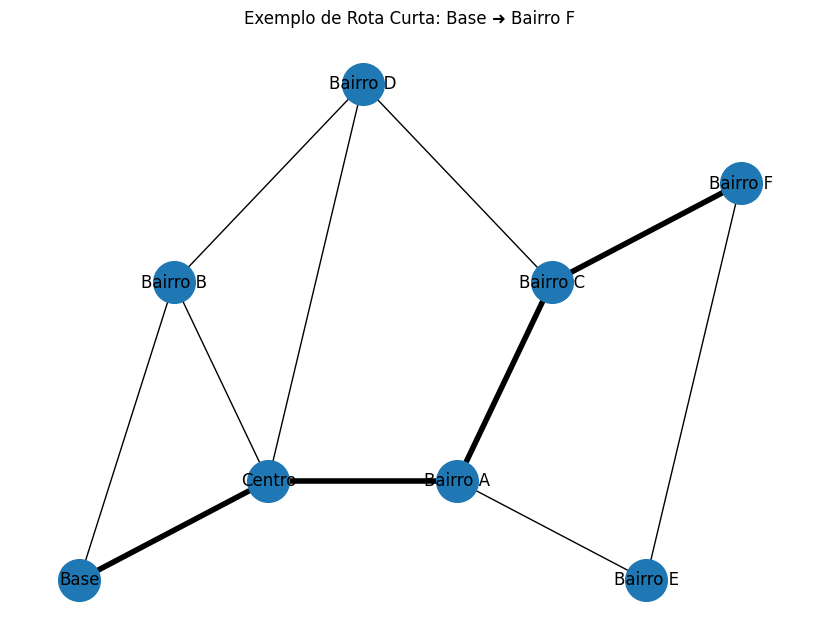

In [8]:
def euclidean(a, b):
    ax, ay = pos[a]
    bx, by = pos[b]
    return math.hypot(ax - bx, ay - by)

origin = "Base"
for target in deliveries:
    path_dijkstra = nx.dijkstra_path(G, origin, target, weight="weight")
    dist_dijkstra = nx.dijkstra_path_length(G, origin, target, weight="weight")

    path_astar = nx.astar_path(G, origin, target, heuristic=lambda u, v: euclidean(u, v), weight="weight")
    dist_astar = nx.astar_path_length(G, origin, target, heuristic=lambda u, v: euclidean(u, v), weight="weight")

    print(f"[Dijkstra] {origin} -> {target}: caminho={path_dijkstra}, distância={dist_dijkstra:.2f}")
    print(f"[A*]       {origin} -> {target}: caminho={path_astar}, distância={dist_astar:.2f}")
    print("-"*70)

# Visualizar a rota para o último destino como exemplo
target = deliveries[-1]
best_path = nx.dijkstra_path(G, origin, target, weight="weight")

plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=True, node_size=900)
path_edges = list(zip(best_path[:-1], best_path[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges, width=4)
plt.title(f"Exemplo de Rota Curta: {origin} ➜ {target}")
plt.show()


## 3) Agrupamento de entregas (K-Means)
Usamos as coordenadas dos nós das entregas como features. O número de clusters `k` pode ser ajustado (cada cluster ≈ rota de um entregador).


Entrega em Bairro A -> Cluster 2
Entrega em Bairro C -> Cluster 0
Entrega em Bairro D -> Cluster 1
Entrega em Bairro F -> Cluster 0


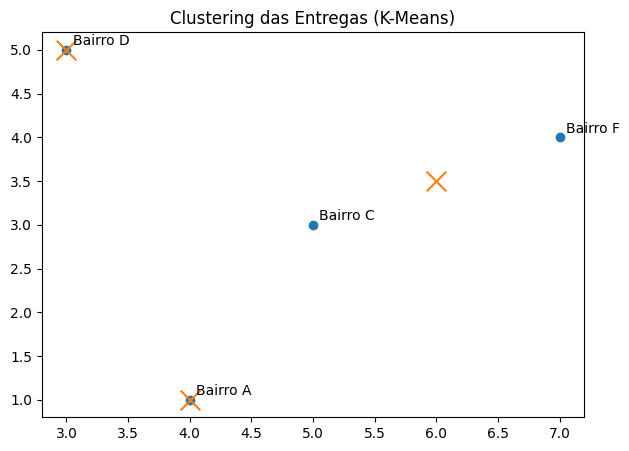

In [16]:
import numpy as np

# Matriz X com coordenadas das entregas
X = np.array([pos[n] for n in deliveries])

k = 3  # utilizei 3 entregadores
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

for i, node in enumerate(deliveries):
    print(f"Entrega em {node} -> Cluster {labels[i]}")

plt.figure(figsize=(7,5))
plt.scatter(X[:,0], X[:,1])
plt.scatter(centers[:,0], centers[:,1], s=200, marker="x")
for i, node in enumerate(deliveries):
    plt.annotate(node, (X[i,0]+0.05, X[i,1]+0.05))
plt.title("Clustering das Entregas (K-Means)")
plt.show()


## 4) Roteiro de visita por cluster (heurística gulosa)
Dentro de cada cluster:
- Começa na **Base**;
- Vai para o **próximo mais próximo** (usando distância Dijkstra).
É um baseline simples (não resolve TSP exato).


In [15]:
from collections import defaultdict

# agrupar entregas por rótulo
cluster_to_nodes = defaultdict(list)
for node, lab in zip(deliveries, labels):
    cluster_to_nodes[lab].append(node)

def dijkstra_distance(a, b):
    return nx.dijkstra_path_length(G, a, b, weight="weight")

def greedy_route(start, targets):
    remaining = set(targets)
    route = [start]
    total = 0.0
    current = start
    while remaining:
        nxt = min(remaining, key=lambda t: dijkstra_distance(current, t))
        total += dijkstra_distance(current, nxt)
        route.append(nxt)
        current = nxt
        remaining.remove(nxt)
    return route, total

total_all = 0.0
for lab, nodes in cluster_to_nodes.items():
    route, cost = greedy_route("Base", nodes)
    total_all += cost
    print(f"Cluster {lab}: entregas={nodes}")
    print(f"  Rota sugerida: {' -> '.join(route)} (custo ~ {cost:.2f})")

print(f"\nDistância total estimada (todas as rotas): {total_all:.2f}")

# Baseline: ordem original das entregas
def chained_cost(origin, sequence):
    total = 0.0
    cur = origin
    for nxt in sequence:
        total += dijkstra_distance(cur, nxt)
        cur = nxt
    return total

baseline_cost = chained_cost("Base", deliveries)
print("Baseline (ordem original):", deliveries, f"-> custo ~ {baseline_cost:.2f}")


Cluster 2: entregas=['Bairro A']
  Rota sugerida: Base -> Bairro A (custo ~ 4.20)
Cluster 0: entregas=['Bairro C', 'Bairro F']
  Rota sugerida: Base -> Bairro C -> Bairro F (custo ~ 8.20)
Cluster 1: entregas=['Bairro D']
  Rota sugerida: Base -> Bairro D (custo ~ 5.40)

Distância total estimada (todas as rotas): 17.80
Baseline (ordem original): ['Bairro A', 'Bairro C', 'Bairro D', 'Bairro F'] -> custo ~ 13.00


## Observações e próximos passos
- Ajustar **k** conforme número de entregadores e volume.
- Considerar janelas de tempo (time windows) e capacidade dos veículos (VRP).
- Incorporar dados de tráfego em tempo real (nível avançado).
- Testar heurísticas/algoritmos avançados para comparar (ex.: Christofides, simulated annealing).
